In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.metrics import roc_curve, auc

fig_dir = './figs/'

custom_stack_order = ['Squ.epi', 'Squ.meta', 'Navicular', 'Para.Squ', 'Para.Clust', 'Glan', 'Leu','Debris', 'LSIL', 'HSIL', 'Adenocarcinoma']
all_cells = ['Squ.epi', 'Squ.meta', 'Navicular', 'Para.Squ', 'Para.Clust', 'Glan', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Leu']

df_all = pd.read_csv('paper-figure_celllist_all.csv')

facilities = {
    '1_CIH': 'C',
    '2_Tsukuba': 'T',
    '3_Kaetsu': 'K',
    '4_Junten': 'J',
}

probability_threshold = 0.8
for param in custom_stack_order:
    df_all[param] = df_all[f'class_count-{probability_threshold}'].apply(ast.literal_eval).apply(lambda x: x.get(param, 0))

df_tested = df_all.query('HPV in ["+", "-"] and Class in ["NILM","ASC-US", "LSIL", "ASC-H", "HSIL", "SCC"]').copy()


In [2]:
#===============================================================================================================================
# Statistical comparison of pointwise AI-vs-Human performance on ROC curve
#===============================================================================================================================

def _interp_tpr_at_fpr(fpr, tpr, fpr_target):
    fpr = np.asarray(fpr); tpr = np.asarray(tpr)
    fpr_target = np.clip(fpr_target, 0.0, 1.0)
    return np.interp(fpr_target, fpr, tpr, left=0.0, right=1.0)

def _interp_fpr_at_tpr(fpr, tpr, tpr_target):
    eps = 1e-12
    tpr_m = np.maximum.accumulate(tpr + eps*np.arange(len(tpr)))
    tpr_target = np.clip(tpr_target, 0.0, 1.0)
    return np.interp(tpr_target, tpr_m, fpr, left=1.0, right=0.0)

def pointwise_ai_vs_human(true_label, ai_score, human_binary,  match="specificity", n_boot=2000, seed=42, grid_points=101):
    """
    When match = 'specificity': Match the AI's ROC to the Human's FPR, and test ΔTPR = TPR_AI(FPR_h) - TPR_Human
    When match = 'sensitivity': Match the AI's ROC to the Human's TPR, and test ΔFPR = FPR_AI(TPR_h) - FPR_Human
    """

    rng = np.random.default_rng(seed)
    y_true = np.asarray(true_label).astype(int)
    y_h = np.asarray(human_binary).astype(int)
    y_ai = np.asarray(ai_score).astype(float)

    # Human points
    TP = np.sum((y_true==1) & (y_h==1))
    FN = np.sum((y_true==1) & (y_h==0))
    FP = np.sum((y_true==0) & (y_h==1))
    TN = np.sum((y_true==0) & (y_h==0))
    tpr_h = TP / (TP + FN) if (TP+FN)>0 else np.nan
    fpr_h = FP / (FP + TN) if (FP+TN)>0 else np.nan

    # AI ROC
    fpr, tpr, _ = roc_curve(y_true, y_ai, pos_label=1)

    if match == "specificity":
        # Compare at the same FPR: AI's TPR interpolation
        ai_tpr_at_hfpr = _interp_tpr_at_fpr(fpr, tpr, fpr_h)
        delta = ai_tpr_at_hfpr - tpr_h   # AI is superior when positive
        metric_name = "ΔTPR (AI - Human) at matched FPR"
    elif match == "sensitivity":
        # Compare at the same TPR: AI's FPR interpolation
        ai_fpr_at_htpr = _interp_fpr_at_tpr(fpr, tpr, tpr_h)
        delta = ai_fpr_at_htpr - fpr_h   # AI is superior when negative (smaller FPR)
        metric_name = "ΔFPR (AI - Human) at matched TPR"
    else:
        raise ValueError("match must be 'specificity' or 'sensitivity'")

    # ---- Bootstrap (stratified) for CI and p-value (two-sided test of zero difference) ----
    pos_idx = np.where(y_true==1)[0]
    neg_idx = np.where(y_true==0)[0]
    n_pos, n_neg = pos_idx.size, neg_idx.size

    deltas = np.empty(n_boot)
    for b in range(n_boot):
        pos_s = rng.choice(pos_idx, size=n_pos, replace=True)
        neg_s = rng.choice(neg_idx, size=n_neg, replace=True)
        idx_s = np.r_[pos_s, neg_s]

        yb = y_true[idx_s]
        hb = y_h[idx_s]
        sb = y_ai[idx_s]

        # Human points
        TPb = np.sum((yb==1) & (hb==1))
        FNb = np.sum((yb==1) & (hb==0))
        FPb = np.sum((yb==0) & (hb==1))
        TNb = np.sum((yb==0) & (hb==0))
        tpr_hb = TPb/(TPb+FNb) if (TPb+FNb)>0 else np.nan
        fpr_hb = FPb/(FPb+TNb) if (FPb+TNb)>0 else np.nan

        fpr_b, tpr_b, _ = roc_curve(yb, sb, pos_label=1)

        if match == "specificity":
            if np.isnan(fpr_hb) or np.isnan(tpr_hb):
                deltas[b] = np.nan
                continue
            ai_tpr = _interp_tpr_at_fpr(fpr_b, tpr_b, fpr_hb)
            deltas[b] = ai_tpr - tpr_hb
        else:
            if np.isnan(fpr_hb) or np.isnan(tpr_hb):
                deltas[b] = np.nan
                continue
            ai_fpr = _interp_fpr_at_tpr(fpr_b, tpr_b, tpr_hb)
            deltas[b] = ai_fpr - fpr_hb

    deltas = deltas[~np.isnan(deltas)]
    if deltas.size == 0:
        raise RuntimeError("Bootstrap failed: no valid resamples.")

    # 95%CI: Percentiles
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    # p-value: From the bootstrap null distribution (without centering) two-sided p ≈ 2*min(Pr(delta<=0), Pr(delta>=0))
    p_two = 2*min(np.mean(deltas<=0), np.mean(deltas>=0))
    p_two = min(1.0, p_two)

    return {
        "match": match,
        "human_point": {"TPR": tpr_h, "FPR": fpr_h},
        "estimate": float(delta),
        "ci95": (float(lo), float(hi)),
        "p_two_sided": float(p_two),
        "note": metric_name
    }

#===============================================================================================================================
# Human vs AI ROC curve
#===============================================================================================================================

def calc_roc(true_label, target_label, n_boot=2000, seed=42, grid_points=101, silent=False):

    y_true = np.asarray(true_label).astype(int)
    y_score = np.asarray(target_label).astype(float)    

    fpr, tpr, thr = roc_curve(y_true, y_score, pos_label=1)
    aucval = auc(fpr, tpr)

    # ====== ROC confidence interval bootstrap (stratified) ======
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    n_pos, n_neg = pos_idx.size, neg_idx.size

    fpr_grid = np.linspace(0, 1, grid_points)
    auc_bs = np.empty(n_boot)
    tpr_band = np.empty((n_boot, fpr_grid.size))

    for b in range(n_boot):
        # Stratified resampling
        pos_s = rng.choice(pos_idx, size=n_pos, replace=True)
        neg_s = rng.choice(neg_idx, size=n_neg, replace=True)
        idx_s = np.r_[pos_s, neg_s]

        yb = y_true[idx_s]
        sb = y_score[idx_s]

        fpr_b, tpr_b, _ = roc_curve(yb, sb, pos_label=1)
        auc_b = auc(fpr_b, tpr_b)
        auc_bs[b] = auc_b

        # Interpolate TPR to common grid (fixing ends)
        tpr_band[b] = np.interp(fpr_grid, fpr_b, tpr_b, left=0.0, right=1.0)

    def perc_ci(x, alpha=0.05):
        lo = np.nanpercentile(x, 100*(alpha/2))
        hi = np.nanpercentile(x, 100*(1-alpha/2))
        return lo, hi

    auc_lo, auc_hi = perc_ci(auc_bs, 0.05)
    tpr_lo = np.nanpercentile(tpr_band, 2.5, axis=0)
    tpr_hi = np.nanpercentile(tpr_band, 97.5, axis=0)

    if not silent:
        print(f"AUC: {aucval:.3f} (95%CI {auc_lo:.3f}-{auc_hi:.3f})")

    return fpr, tpr, fpr_grid, tpr_lo, tpr_hi, aucval, auc_lo, auc_hi


def wilson_ci(k, n, z=1.96):
    # Wilson 95%CI (Sensitivity/Specificity)
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
    return (max(0.0, center - half), min(1.0, center + half))


def calc_human_performance(true_label, target_label, name):
    TP = np.sum((true_label==1) & (target_label==1))
    FN = np.sum((true_label==1) & (target_label==0))
    FP = np.sum((true_label==0) & (target_label==1))
    TN = np.sum((true_label==0) & (target_label==0))
    tpr_h = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    fpr_h = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    spe_h = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    sens_ci = wilson_ci(TP, TP+FN)
    spec_ci = wilson_ci(TN, TN+FP)

    print(f"{name} -- TP:{TP}, FN:{FN}, FP:{FP}, TN:{TN}, TPR:{tpr_h:.3f}, FPR:{fpr_h:.3f}, SPE:{spe_h:.3f}")

    plt.scatter([fpr_h], [tpr_h], s=40, marker='o', edgecolor='gray', label=name, zorder=5)
    yerr_lower = max(0, tpr_h - sens_ci[0])
    yerr_upper = max(0, sens_ci[1] - tpr_h)
    x_ci_low  = 1 - spec_ci[1]
    x_ci_high = 1 - spec_ci[0]
    xerr_lower = max(0, fpr_h - x_ci_low)
    xerr_upper = max(0, x_ci_high - fpr_h)
    plt.errorbar([fpr_h], [tpr_h],
                xerr=[[xerr_lower],[xerr_upper]],
                yerr=[[yerr_lower],[yerr_upper]],
                fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=4)
    
    return {
        "TPR": tpr_h,
        "FPR": fpr_h,
        "Specificity": spe_h,
        "Sensitivity CI": sens_ci,
        "Specificity CI": spec_ci
    }



def draw_roc_curve(df, ai_column, title='', figure_name=''):

    df = df[df['HPV'].notna() & df[ai_column].notna() & df['Class'].notna()]

    true_label = (df['HPV']=='+').astype(int)
    target_label = df[ai_column]

    fpr, tpr, fpr_grid, tpr_lo, tpr_hi, aucval, auc_lo, auc_hi = calc_roc(true_label, target_label)

    # ====== Draw AI ROC ======
    plt.figure(figsize=(5,5))
    # Draw ROC curve
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'HPV+ by AI (AUC = {aucval:.2f})')
    # Draw confidence interval
    plt.fill_between(fpr_grid, tpr_lo, tpr_hi, alpha=0.2, color='orange')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # ====== Human performance ======
    lsil_plus = calc_human_performance(true_label, df['Class'].isin(['LSIL', 'ASC-H', 'HSIL', 'SCC']).astype(int), 'LSIL+ by human experts')
    ascus_plus = calc_human_performance(true_label, df['Class'].isin(['ASC-US', 'LSIL', 'ASC-H', 'HSIL', 'SCC']).astype(int), 'ASC-US+ by human experts')

    # ---- AI vs Human (Point comparison) ----
    human_lsil_plus = df['Class'].isin(['LSIL','ASC-H','HSIL','SCC']).astype(int).values
    human_ascus_plus = df['Class'].isin(['ASC-US','LSIL','ASC-H','HSIL','SCC']).astype(int).values

    # 1) Same specificity (Compare TPR at matched FPR to Humans -> AI is superior when ΔTPR > 0)
    res_lsil_spec = pointwise_ai_vs_human(true_label, target_label, human_lsil_plus, match="specificity", n_boot=2000, seed=42)
    res_ascus_spec = pointwise_ai_vs_human(true_label, target_label, human_ascus_plus, match="specificity", n_boot=2000, seed=42)
    print("AI vs Human(LSIL+) at matched specificity:", res_lsil_spec)
    print("AI vs Human(ASC-US+) at matched specificity:", res_ascus_spec)

    # 2) Same sensitivity (Compare FPR at matched TPR to Humans -> AI is superior when ΔFPR < 0)
    res_lsil_sens = pointwise_ai_vs_human(true_label, target_label, human_lsil_plus, match="sensitivity", n_boot=2000, seed=42)
    res_ascus_sens = pointwise_ai_vs_human(true_label, target_label, human_ascus_plus, match="sensitivity", n_boot=2000, seed=42)
    print("AI vs Human(LSIL+) at matched sensitivity:", res_lsil_sens)
    print("AI vs Human(ASC-US+) at matched sensitivity:", res_ascus_sens)


    # Formatting
    plt.xlabel("False positive rate", fontsize=16)
    plt.ylabel("True positive rate", fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.margins(x=0.01, y=0.01)
    plt.legend(loc="lower right", fontsize=12, frameon=False)
    plt.grid(False)
    plt.tight_layout()
    if title != '':
        plt.title(title, fontsize=16)
    if figure_name != '':
        plt.savefig(figure_name, dpi=300)
    plt.show()


AUC: 0.698 (95%CI 0.662-0.732)
LSIL+ by human experts -- TP:225, FN:248, FP:34, TN:307, TPR:0.476, FPR:0.100, SPE:0.900
ASC-US+ by human experts -- TP:362, FN:111, FP:207, TN:134, TPR:0.765, FPR:0.607, SPE:0.393
AI vs Human(LSIL+) at matched specificity: {'match': 'specificity', 'human_point': {'TPR': 0.47568710359408034, 'FPR': 0.09970674486803519}, 'estimate': -0.1331923890063425, 'ci95': (-0.19557157958320748, -0.06976744186046513), 'p_two_sided': 0.0, 'note': 'ΔTPR (AI - Human) at matched FPR'}
AI vs Human(ASC-US+) at matched specificity: {'match': 'specificity', 'human_point': {'TPR': 0.7653276955602537, 'FPR': 0.6070381231671554}, 'estimate': 0.0564191850101563, 'ci95': (0.006390432174639876, 0.10742248062015501), 'p_two_sided': 0.034, 'note': 'ΔTPR (AI - Human) at matched FPR'}
AI vs Human(LSIL+) at matched sensitivity: {'match': 'sensitivity', 'human_point': {'TPR': 0.47568710359408034, 'FPR': 0.09970674486803519}, 'estimate': 0.0938416421818089, 'ci95': (0.045452101622020055, 

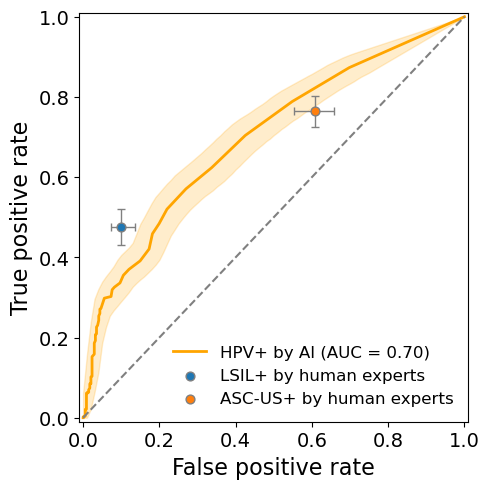

AUC: 0.734 (95%CI 0.673-0.790)
LSIL+ by human experts -- TP:44, FN:83, FP:10, TN:129, TPR:0.346, FPR:0.072, SPE:0.928
ASC-US+ by human experts -- TP:70, FN:57, FP:55, TN:84, TPR:0.551, FPR:0.396, SPE:0.604
AI vs Human(LSIL+) at matched specificity: {'match': 'specificity', 'human_point': {'TPR': 0.3464566929133858, 'FPR': 0.07194244604316546}, 'estimate': -0.015748031496062964, 'ci95': (-0.11023622047244097, 0.13385826771653542), 'p_two_sided': 1.0, 'note': 'ΔTPR (AI - Human) at matched FPR'}
AI vs Human(ASC-US+) at matched specificity: {'match': 'specificity', 'human_point': {'TPR': 0.5511811023622047, 'FPR': 0.39568345323741005}, 'estimate': 0.16955380577427814, 'ci95': (0.07173988119906065, 0.2716624910522549), 'p_two_sided': 0.002, 'note': 'ΔTPR (AI - Human) at matched FPR'}
AI vs Human(LSIL+) at matched sensitivity: {'match': 'sensitivity', 'human_point': {'TPR': 0.3464566929133858, 'FPR': 0.07194244604316546}, 'estimate': 0.007194244595179852, 'ci95': (-0.06235011990597387, 0.071

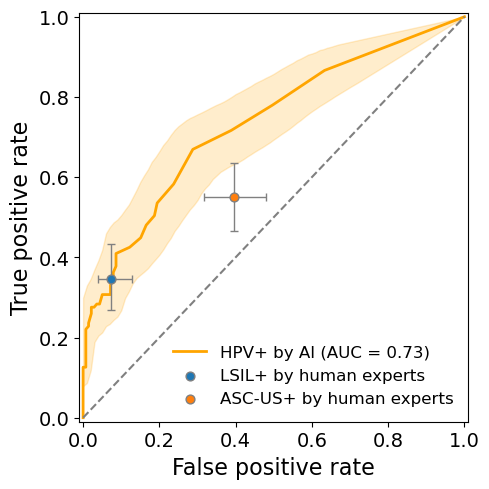

In [3]:
draw_roc_curve(df_tested, 'LSIL', figure_name=f'{fig_dir}fig7h_roc_hpv_lsil_All.svg')
draw_roc_curve(df_tested.query('Facility == "1_CIH"'), 'LSIL', figure_name=f'{fig_dir}fig7i_roc_hpv_lsil_C.svg')